In [32]:
import numpy as np 
import torch 
from torch.autograd import Variable
import sys 
from sfcn.sfcn_load import give_pretrained_sfcn
from data.oasis.load_oasis3 import give_oasis_data
import matplotlib.pyplot as plt 
from matplotlib.colors import Normalize

In [33]:
def plot_3d_kernels(kernels):
    
    n_in_channels=kernels.shape[0]
    n_out_channels=kernels.shape[1]
    n_slices=kernels.shape[2]
    
    nm_kernel=Normalize(vmin=kernels.min(), vmax=kernels.max(), clip=False)
    
    fig,ax=plt.subplots(nrows=n_slices*n_out_channels,ncols=n_in_channels,figsize=(n_in_channels,n_slices*n_out_channels),squeeze=False)
    
    for out_ in range(n_out_channels):
        for in_ in range(n_in_channels):
            for j in range(n_slices):
                ax[j+n_slices*out_,in_].tick_params(axis='x',bottom = False, top = False)
                ax[j+n_slices*out_,in_].tick_params(axis='y',left= False, right = False)
                ax[j+n_slices*out_,in_].imshow(kernels[in_,out_,j],'gray')#,norm=nm_kernel)
                ax[j+n_slices*out_,in_].set_xticklabels([])
                ax[j+n_slices*out_,in_].set_yticklabels([])

    plt.subplots_adjust(wspace=0., hspace=0.3)

In [3]:
model=give_pretrained_sfcn("0", "age")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Number of GPUs: ", torch.cuda.device_count())
model=model.to(device)

Load model for age - run: 0
Number of GPUs:  4


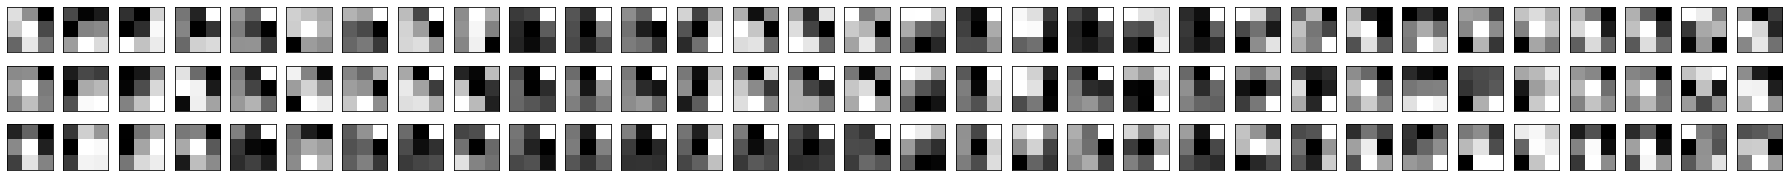

In [4]:
kernels=model.module.feature_extractor[0][0].weight.data.cpu().detach()
plot_3d_kernels(kernels)

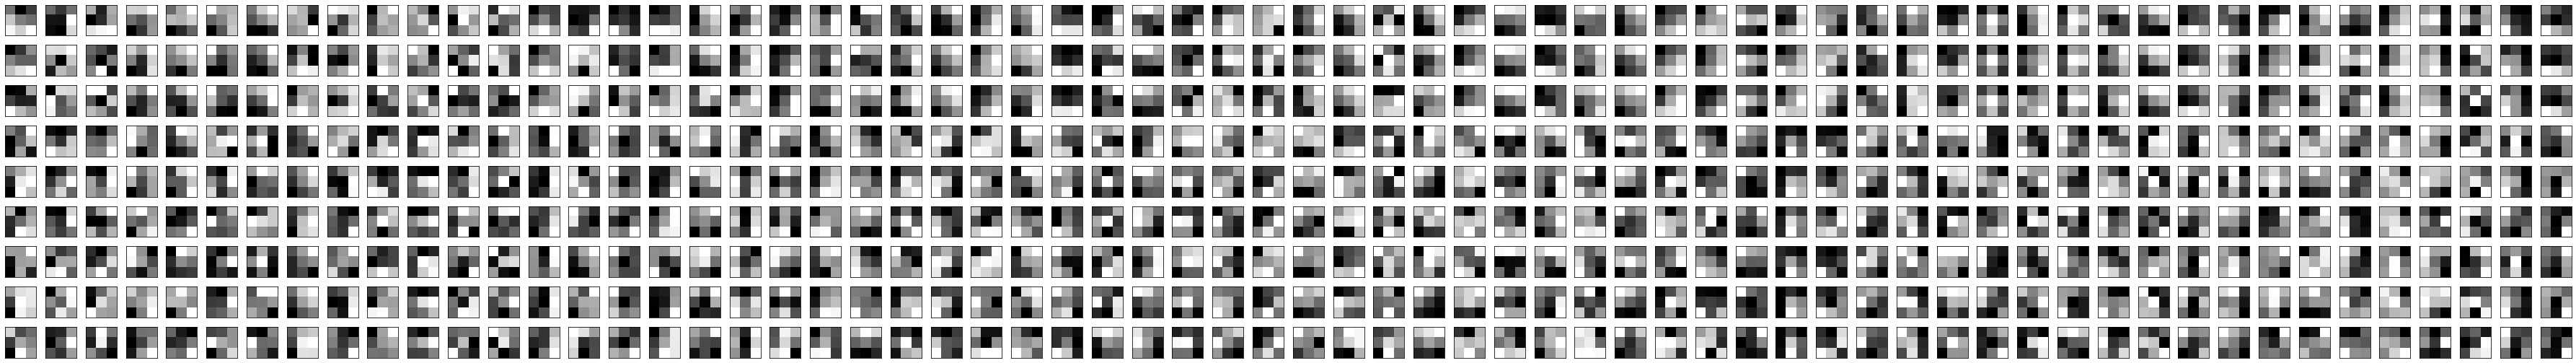

In [5]:
kernels=model.module.feature_extractor[1][0].weight.data.cpu().detach()
kernels=kernels[:,:3]
plot_3d_kernels(kernels)

In [34]:
def compute_activation(model,x, filter_index,device=None):
    '''
        model - SFCN 
        x - input MRI 
        filter_index - int 
    '''
    activation = model.module.feature_extractor(x)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, filter_index]
    return torch.mean(filter_activation)

In [35]:
def maximize_activation(model,x,filter_index,n_epochs,lr,alpha=1.,device=None,print_every=100):
    if device is not None: 
        x=x.to(device)
    x = Variable(x, requires_grad=True) 
    model.module.train_nothing()
    model.eval()
    loss_list=[]
    for it in range(n_epochs):
        loss=compute_activation(model,x,filter_index,device)
        loss.backward()
        x.data+=lr*x.grad.data-alpha*x.data
        x.grad.zero_()
        if it%print_every==0:
            print("Epoch: %3d || Activ: %.6f"%(it,loss))
        loss_list.append(loss)
    return(x,loss_list)

In [36]:
_,train_loader=give_oasis_data('train', batch_size=1,
                                        num_workers=4,
                                        shuffle=True,
                                        debug='debug',
                                        preprocessing='min',
                                        task='age',
                                        share=1.)

Loading share 1.00 OASIS train debug data.


In [40]:
def plot_random_filter_activation(model,x,filter_index,n_epochs,lr,alpha=1.,device=None,print_every=100,permute=False):
    model.channels[-1]
    
    
    if permute:
        x=x.flatten()
        x=x[torch.randperm(x.shape[0])]
        x=x.reshape(shape)
    
    x_np=x.squeeze().cpu().detach().numpy()

    
    filter_index=torch.randint(low=0,high=40,size=[]).item()
    maximizing_image,loss_list=maximize_activation(model,x,filter_index,n_epochs,lr,alpha,device)
    maximizing_image=maximizing_image.squeeze().cpu().detach().numpy()
    fig, ax=plt.subplots(ncols=2,nrows=1,figsize=(20,10))
    ind=80
    ax[0].imshow(x_np[ind],'gray')
    ax[1].imshow(maximizing_image[ind],'gray')

In [53]:

n_it=1
lr_list=[0.1,1.,10.,100.,0.1]
n_epochs=50000
alpha_list=[1e-6,1e-5,1e-4,1e-3]


for permute in [True, False]:
    for it in range(n_it):
        x,y=next(iter(train_loader))
        shape=x.shape
        if permute:
            x=x.flatten()
            x=x[torch.randperm(x.shape[0])]
            x=x.reshape(shape)
        x_np=x.squeeze().cpu().detach().numpy()
        filter_index=torch.randint(low=0,high=40,size=[]).item()
        alpha_index=torch.randint(low=0,high=len(alpha_list),size=[]).item()
        lr_index=torch.randint(low=0,high=len(lr_list),size=[]).item()
        alpha=alpha_list[alpha_index]
        lr=lr_list[lr_index]
        maximizing_image,loss_list=maximize_activation(model,x,filter_index,n_epochs,lr,alpha,device)
        maximizing_image=maximizing_image.squeeze().cpu().detach().numpy()
        fig, ax=plt.subplots(ncols=3,nrows=1,figsize=(20,10))
        ind=80
        ax[0].imshow(x_np[ind],'gray')
        ax[1].imshow(maximizing_image[ind],'gray')
        ax[2].plot(loss_list)
        fig.suptitle("Learning rate: %.5f || Alpha: %.5f"%(lr,alpha))
        print("Difference:", np.linalg.norm(maximizing_image-x_np))
        filename="Max_activ_"+str(it)+"_"+str(filter_index)+".pdf"
        plt.savefig(filename)


Epoch:   0 || Loss: 0.000000
Epoch: 100 || Loss: 0.189479
Epoch: 200 || Loss: 3.983577
Epoch: 300 || Loss: 20.971676
Epoch: 400 || Loss: 41.267597
Epoch: 500 || Loss: 57.872051
Epoch: 600 || Loss: 72.868958
Epoch: 700 || Loss: 87.390068
Epoch: 800 || Loss: 101.502235
Epoch: 900 || Loss: 115.564690
Epoch: 1000 || Loss: 129.512009
Epoch: 1100 || Loss: 143.498627
Epoch: 1200 || Loss: 157.480942
Epoch: 1300 || Loss: 171.461136
Epoch: 1400 || Loss: 185.420502
Epoch: 1500 || Loss: 199.484680
Epoch: 1600 || Loss: 213.655029
Epoch: 1700 || Loss: 227.807510
Epoch: 1800 || Loss: 241.961990
Epoch: 1900 || Loss: 256.066071
Epoch: 2000 || Loss: 270.256989
Epoch: 2100 || Loss: 284.510254
Epoch: 2200 || Loss: 298.496979
Epoch: 2300 || Loss: 312.506927
Epoch: 2400 || Loss: 326.385620
Epoch: 2500 || Loss: 340.126038
Epoch: 2600 || Loss: 353.513275
Epoch: 2700 || Loss: 366.631775
Epoch: 2800 || Loss: 379.584320
Epoch: 2900 || Loss: 392.275421
Epoch: 3000 || Loss: 404.625641
Epoch: 3100 || Loss: 416.9221

KeyboardInterrupt: 

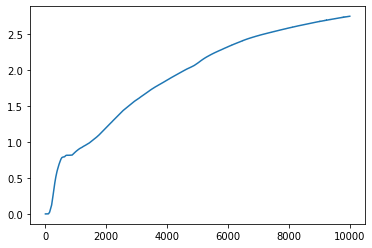

In [50]:
plt.plot(loss_list)

Difference: 658.1227


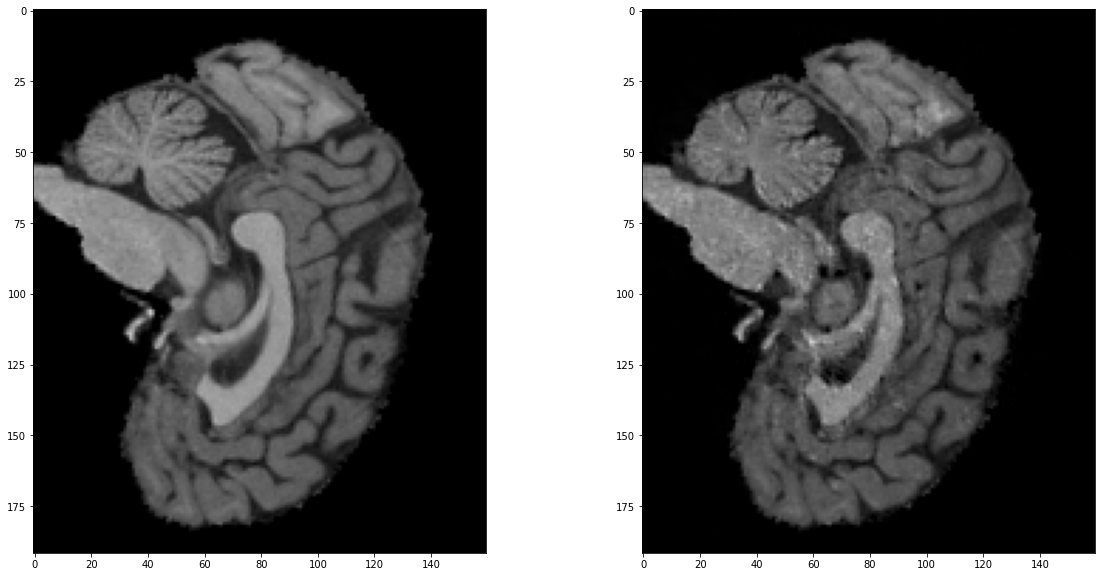

In [45]:
nm_x=Normalize(vmin=x.min(), vmax=x.max(), clip=True)
fig, ax=plt.subplots(ncols=2,nrows=1,figsize=(20,10))
ind=80
ax[0].imshow(x_np[ind],'gray',norm=nm_x)
ax[1].imshow(maximizing_image[ind],'gray',norm=nm_x)
print("Difference:", np.linalg.norm(maximizing_image-x_np))

In [8]:
#Function which maximimzes the probability of a specific bin:
def maximize_specific_bin(model,x,filter_index,n_epochs,lr,alpha=1.,bin_id=0,device=None):
    if device is not None: 
        x=x.to(device)
    x = Variable(x, requires_grad=True) 
    model.module.train_nothing()
    model.eval()
    loss_list=[]
    for it in range(n_epochs):
        loss=model(x)[bin_id]
        loss.backward()
        x.data=x.data+lr*x.grad.data-alpha*x.data
        x.grad.zero_()
        loss_list.append(loss)
    return(x,loss_list)

SyntaxError: non-default argument follows default argument (<ipython-input-8-52c62d690a7c>, line 2)